In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(os.path.dirname(current_dir))
sys.path.insert(0, parent_dir) 

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sOED import SOED
from sOED import PGsOED
from sOED.utils import *

def linear_model(stage, theta, d, xp=None):
    """
    Linear model function G(theta, d) = theta * d

    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    theta : np.ndarray of size (n_sample, n_param)
        The value of unknown linear model parameters.
    d : np.ndarray of size (n_sample, n_design)
        The design variable.
    xp : np.ndarray of size (n_sample, n_phys_state), optional(default=None)
        The physical state.

    Returns
    -------
    numpy.ndarray of size (n_sample, n_obs)
        The output of the linear model.
    """
    global count
    count += max(len(theta), len(d))
    return theta * d

def reward_fun(stage, xb, xp, d, y):
    """
    Non-KL-divergence based reward function g_k(x_k, d_k, y_k)
    
    Parameters
    ----------
    stage : int
        The stage index of the experiment.
    xb : numpy.ndarray of size (n_grid ** n_param, n_param + 1)
        Grid discritization of the belief state.
    xp : np.ndarray of size (n_phys_state)
        The physical state.
    d : np.ndarray of size (n_design)
        The design variable.
    y : np.ndarray of size (n_obs)
        The observation.

    Returns
    -------
    A float which is the reward.
    """
    if stage < n_stage:
        return 0
    else:
        dx = xb[1, 0] - xb[0, 0]
        mean = (xb[:, 1] * xb[:, 0]).sum() * dx
        var = (xb[:, 1] * xb[:, 0] ** 2).sum() * dx - mean ** 2
        return -2 * (np.log(var) - np.log(2)) ** 2
    
# For a linear model with normal prior and additive Gaussian noise,
# the posterior is also a normal distribution.
# This function updates the mean and std after observing new data y 
# under design d.
def update_mean_std(loc, scale, noise_scale, d, y):
    loc_new = ((y * d * scale ** 2 + loc * noise_scale ** 2) 
               / (d ** 2 * scale ** 2 + noise_scale ** 2))
    scale_new = np.sqrt(scale ** 2 * noise_scale ** 2 
                        / (d**2 * scale ** 2 + noise_scale ** 2))
    return loc_new, scale_new

In [5]:
n_stage = 2 # Number of stages.
n_param = 1 # Number of parameters.
n_design = 1 # Number of design variables.
n_obs = 1 # Number of observations.

prior_type = "normal" # "normal" for normal dist, "uniform" for uniform dist.
prior_loc = 0 # mean for normal, lower bound for uniform.
prior_scale = 3 # std for normal, range for uniform.
prior_info = [(prior_type, prior_loc, prior_scale),]

design_bounds = [(0.1, 3.0),] # lower and upper bounds of design variables.

# Noise if following N(noise_loc, noise_base_scale + noise_ratio_scale * abs(G))
noise_loc = 0
noise_base_scale = 1
noise_ratio_scale = 0
noise_info = [(noise_loc, noise_base_scale, noise_ratio_scale),]

# Number of grid points on each dimension of parameter space to store PDFs.
n_grid = 50

# Method to sample posterior samples, could be "Rejection" or "MCMC", default
# is "MCMC".
post_rvs_method = "Rejection"


# Random state could be eith an integer or None.
random_state = 2021

In [41]:
soed = PGsOED(model_fun=linear_model,
              n_stage=n_stage,
              n_param=n_param,
              n_design=n_design,
              n_obs=n_obs,
              prior_info=prior_info,
              design_bounds=design_bounds,
              noise_info=noise_info,
              reward_fun=reward_fun,
              n_grid=n_grid,
              post_rvs_method=post_rvs_method,
              random_state=random_state,
              actor_dimns=[80, 80],
              critic_dimns=[80, 80],
              double_precision=True)

In [42]:
actor_optimizer = optim.SGD(soed.actor_net.parameters(), lr=0.15)

n_critic_update = 100
critic_optimizer = optim.SGD(soed.critic_net.parameters(), lr=0.02)

In [43]:
count = 0
soed.soed(n_update=30,
          n_traj=1000,
          actor_optimizer=actor_optimizer,
          n_critic_update=n_critic_update,
          critic_optimizer=critic_optimizer,
          design_noise_scale=0.2, 
          design_noise_decay=0.95)

Update Level 0
******************************
Averaged total reward:  -9.549
Update Level 1
******************************
Averaged total reward:  -1.25
Update Level 2
******************************
Averaged total reward:  0.3865
Update Level 3
******************************
Averaged total reward:  0.2532
Update Level 4
******************************
Averaged total reward:  0.2905
Update Level 5
******************************
Averaged total reward:  0.4549
Update Level 6
******************************
Averaged total reward:  0.5622
Update Level 7
******************************
Averaged total reward:  0.587
Update Level 8
******************************
Averaged total reward:  0.6078
Update Level 9
******************************
Averaged total reward:  0.5991
Update Level 10
******************************
Averaged total reward:  0.6339
Update Level 11
******************************
Averaged total reward:  0.6024
Update Level 12
******************************
Averaged total reward:  0.685

In [44]:
print("\nForward model evaluations: ", count)


Forward model evaluations:  3060000


In [45]:
soed.asses(10000)

******************************
Averaged total reward:  0.7751


0.7750995973884537

In [24]:
np.std(soed.rewards_hist.sum(-1)) / np.sqrt(10000)

0.005508504211080853

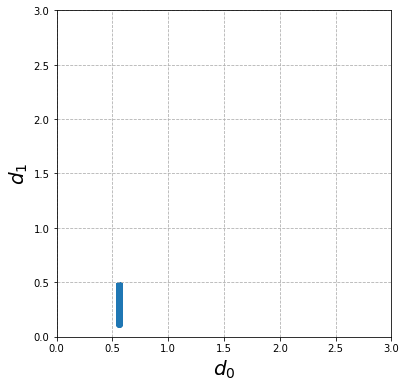

In [25]:
plt.figure(figsize=(6, 6))
plt.scatter(soed.dcs_hist[:, 0, 0], soed.dcs_hist[:, 1, 0])
plt.xlim(0, 3)
plt.ylim(0, 3)
plt.xlabel("$d_0$", fontsize=20)
plt.ylabel("$d_1$", fontsize=20)
plt.grid(ls='--')